In [390]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [391]:
train_data = pd.read_csv("marketing_campaign.csv.xls",sep='\t') #creating dataframe from csv file 
train_data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [392]:
# Specifying the features and target
features = ['Year_Birth','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',
            'Kidhome','Teenhome','Education','Marital_Status']
target = 'Income'

#removing rows which have NaN values for target variable
train_data = train_data[train_data['Income'].notna()] 

#converting the income into 1000s of $
train_data['Income'] = (train_data['Income'])/1000 

train_data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58.138,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46.344,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71.613,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26.646,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58.293,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [393]:
# Splitting the data into train and cross-validation sets
X_train, X_cv, y_train, y_cv = train_test_split(train_data[features], train_data[target], test_size=0.3, random_state=42)

# Identifying categorical features and target feature
cat_features = ['Education','Marital_Status']
target = 'Income'

In [394]:
# Creating the CatBoost Pool
train_pool = Pool(X_train, y_train, cat_features=cat_features)
cv_pool = Pool(X_cv, y_cv, cat_features=cat_features)

# Initializing and Training the model
model = CatBoostRegressor(iterations=1000, learning_rate=0.032, depth=4, verbose=100,l2_leaf_reg=13,border_count=300,bagging_temperature=2)
model.fit(train_pool,early_stopping_rounds=50)

0:	learn: 26.3557121	total: 1.81ms	remaining: 1.81s
100:	learn: 19.2914058	total: 53.1ms	remaining: 472ms
200:	learn: 18.7042086	total: 92.5ms	remaining: 368ms
300:	learn: 18.5199015	total: 136ms	remaining: 316ms
400:	learn: 17.9583892	total: 176ms	remaining: 263ms
500:	learn: 16.6417325	total: 218ms	remaining: 217ms
600:	learn: 16.1971300	total: 258ms	remaining: 172ms
700:	learn: 16.0430847	total: 296ms	remaining: 126ms
800:	learn: 15.8542318	total: 335ms	remaining: 83.1ms
900:	learn: 15.1562779	total: 374ms	remaining: 41.1ms
999:	learn: 14.6014248	total: 413ms	remaining: 0us


In [395]:
#checking Mean Squared Error on Training and Cross Validation Set
y_pred_train=model.predict(train_pool)
mse = mean_squared_error(y_train, y_pred_train)
print(f"\nMean Squared Error on training: {mse}")
y_pred = model.predict(cv_pool)
mse = mean_squared_error(y_cv, y_pred)
print(f"Mean Squared Error on cross-validation: {mse}")


Mean Squared Error on training: 222.20657130000765
Mean Squared Error on cross-validation: 202.5379030322347


In [396]:
# Estimating the prediction interval (85% prediction interval)
residuals = y_train - y_pred_train
lower_bound = model.predict(X_train) + np.percentile(residuals, 7.5)
upper_bound = model.predict(X_train) + np.percentile(residuals, 92.5)
prediction_range = np.array(list(zip(lower_bound, upper_bound)))
#cross validation set
res=y_cv-y_pred
lower=model.predict(X_cv)+np.percentile(residuals,7.5)
upper=model.predict(X_cv)+np.percentile(residuals,92.5)
pred_range=np.array(list(zip(lower,upper)))

In [397]:
#checking the predictions for 10 random indices of Cross Validation Set
np.random.seed(14)
indices = np.random.choice(len(y_cv), size=10, replace=False)
for i in range(10):
    print(f"The predicted interval is : {pred_range[indices][i]} and The Actual value from training set is : {y_cv.values[indices][i]}", end=' -------- ')
    if pred_range[indices][i][0]<=y_cv.values[indices][i] and pred_range[indices][i][1] >=y_cv.values[indices][i]:
        print('Correct Prediciton!')
    else:
        print('Wrong Prediction!')

The predicted interval is : [55.39133703 78.72925557] and The Actual value from training set is : 63.81 -------- Correct Prediciton!
The predicted interval is : [56.95277007 80.2906886 ] and The Actual value from training set is : 75.127 -------- Correct Prediciton!
The predicted interval is : [64.39214262 87.73006116] and The Actual value from training set is : 64.497 -------- Correct Prediciton!
The predicted interval is : [19.18195322 42.51987176] and The Actual value from training set is : 19.444 -------- Correct Prediciton!
The predicted interval is : [28.12421955 51.46213808] and The Actual value from training set is : 34.704 -------- Correct Prediciton!
The predicted interval is : [33.63830781 56.97622635] and The Actual value from training set is : 40.548 -------- Correct Prediciton!
The predicted interval is : [64.33444933 87.67236787] and The Actual value from training set is : 69.267 -------- Correct Prediciton!
The predicted interval is : [36.14977541 59.48769395] and The A

In [398]:
#Prediction Interval Coverage Probability(PICP)
#it is a metric used to evaluate the performance of prediction intervals in regression models
def picp(y_true, lower_bound, upper_bound):
    return np.sum((y_true >= lower_bound) & (y_true <= upper_bound))

In [399]:
#checking accuracy on training set
picp_train = picp(y_train, lower_bound, upper_bound)/len(y_train)
acc_train=picp_train*100
print(f"Accuracy on training set is : {acc_train:.2f}%.")

Accuracy on training set is : 84.91%.


In [400]:
#checking accuracy on cross validation set
picp_cv=picp(y_cv,low,upper)/len(y_cv)
acc_train=picp_cv*100
print(f"Accuracy on cross validation set is : {acc_train:.2f}%.")

Accuracy on cross validation set is : 81.95%.


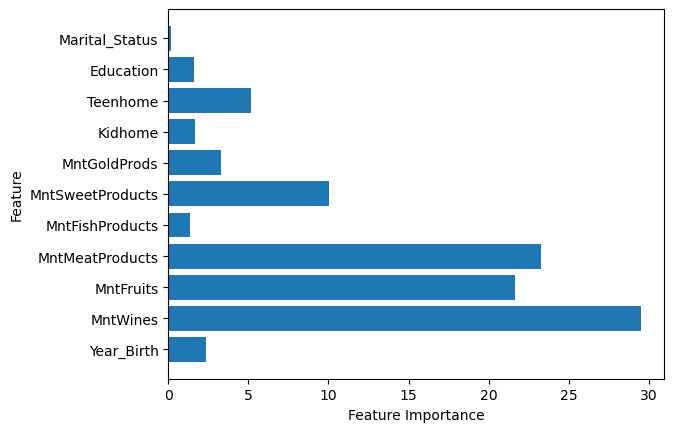

In [401]:
# Visualizing feature importance
feature_importances = model.get_feature_importance(Pool(train_data[features], train_data[target], cat_features=cat_features))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [402]:
#defining a function to visualise the predicted vs actual values
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue',label='Actual')
    plt.scatter(range(len(y_pred)), y_pred, color='red',label='Prediction')
    plt.title(regressorName)
    plt.legend()
    plt.show()
    return


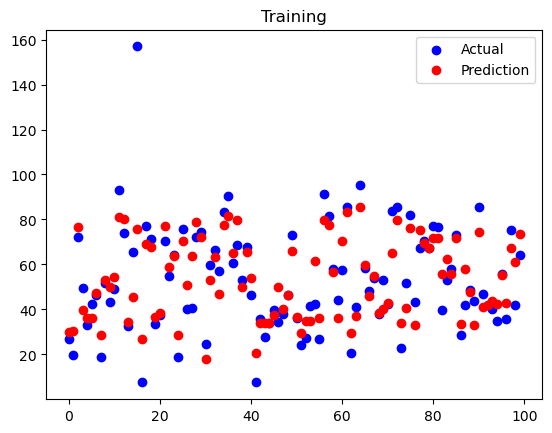

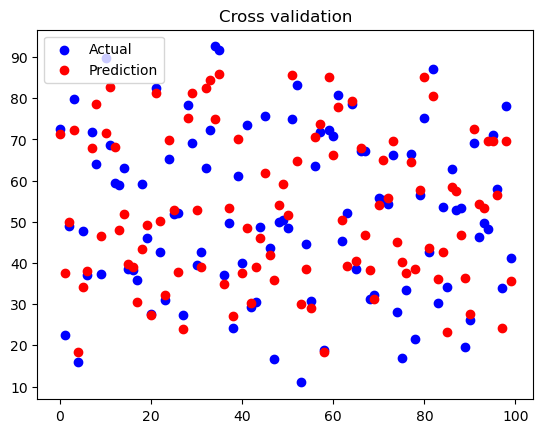

In [403]:
#choosing 100 random indices to plot
indi = np.random.choice(min(len(y_pred_train),len(y_pred)), size=100, replace=False)

plotGraph(y_train.values[indi], y_pred_train[indi], "Training")
plotGraph(y_cv.values[indi], y_pred[indi], "Cross validation")

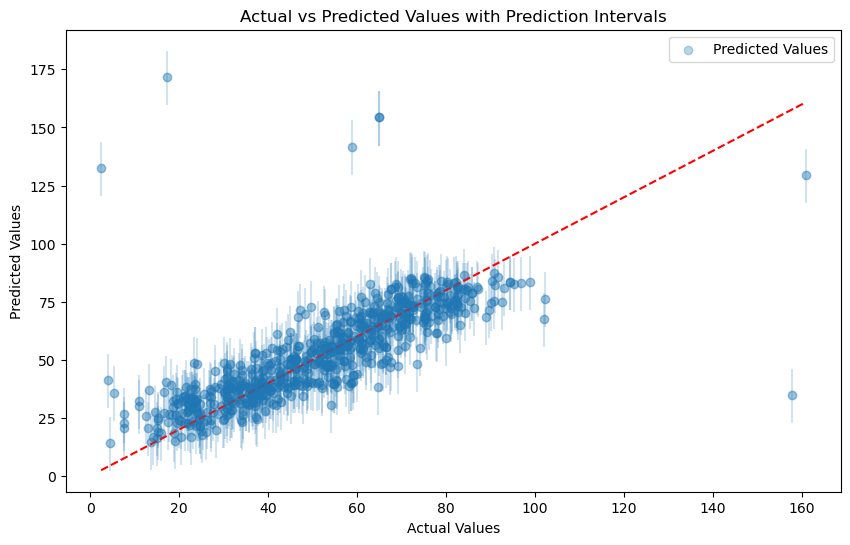

In [404]:
#plotting using error bar
plt.figure(figsize=(10, 6))
plt.scatter(y_cv, y_pred, alpha=0.3, label='Predicted Values')
plt.errorbar(y_cv, y_pred, yerr=[y_pred - lower, upper - y_pred], fmt='o', alpha=0.2)
plt.plot([min(y_cv), max(y_cv)], [min(y_cv), max(y_cv)], 'r--') # 45-degree line  
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values with Prediction Intervals')
plt.legend()
plt.show()

In [405]:
#sampling 100 random values of cross validation set for better visualisation
np.random.seed(49)
indices = np.random.choice(len(y_cv), size=100, replace=False)

# sampled values
y_test_sample = y_cv.values[indices]
y_test_pred_sample = y_pred[indices]
lower_bound_sample = lower[indices]
upper_bound_sample = upper[indices]

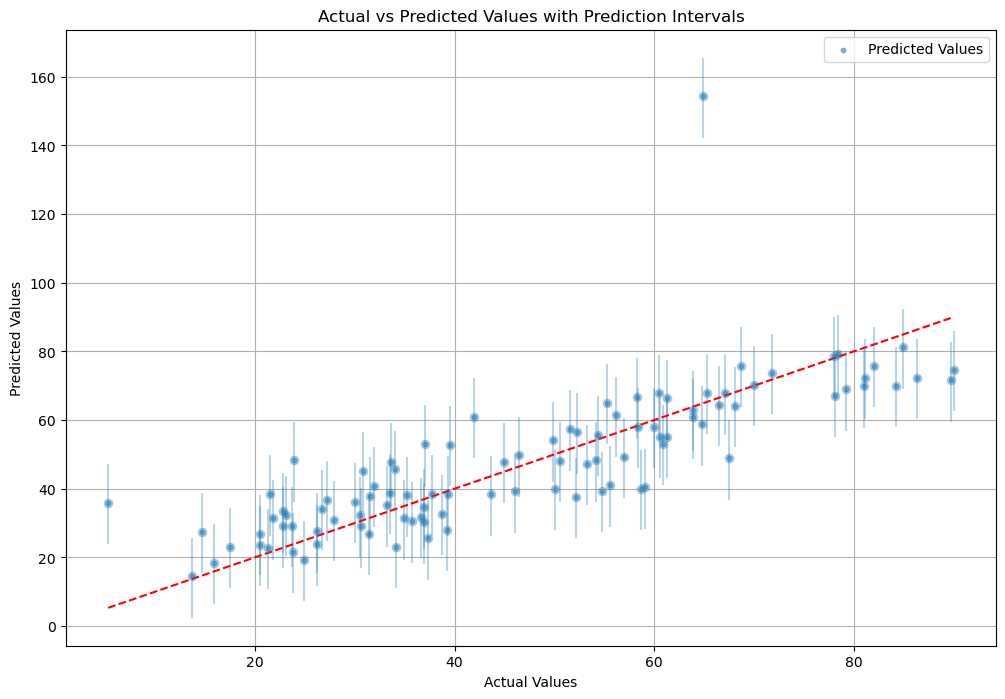

In [406]:
# Plot with Prediction Intervals
plt.figure(figsize=(12, 8))
plt.scatter(y_test_sample, y_test_pred_sample, alpha=0.5, label='Predicted Values', s=10)
plt.errorbar(y_test_sample, y_test_pred_sample, yerr=[y_test_pred_sample - lower_bound_sample, upper_bound_sample - y_test_pred_sample], fmt='o', alpha=0.3)
plt.plot([min(y_test_sample), max(y_test_sample)], [min(y_test_sample), max(y_test_sample)], 'r--')  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values with Prediction Intervals')
plt.grid(True)
plt.legend()
plt.show()